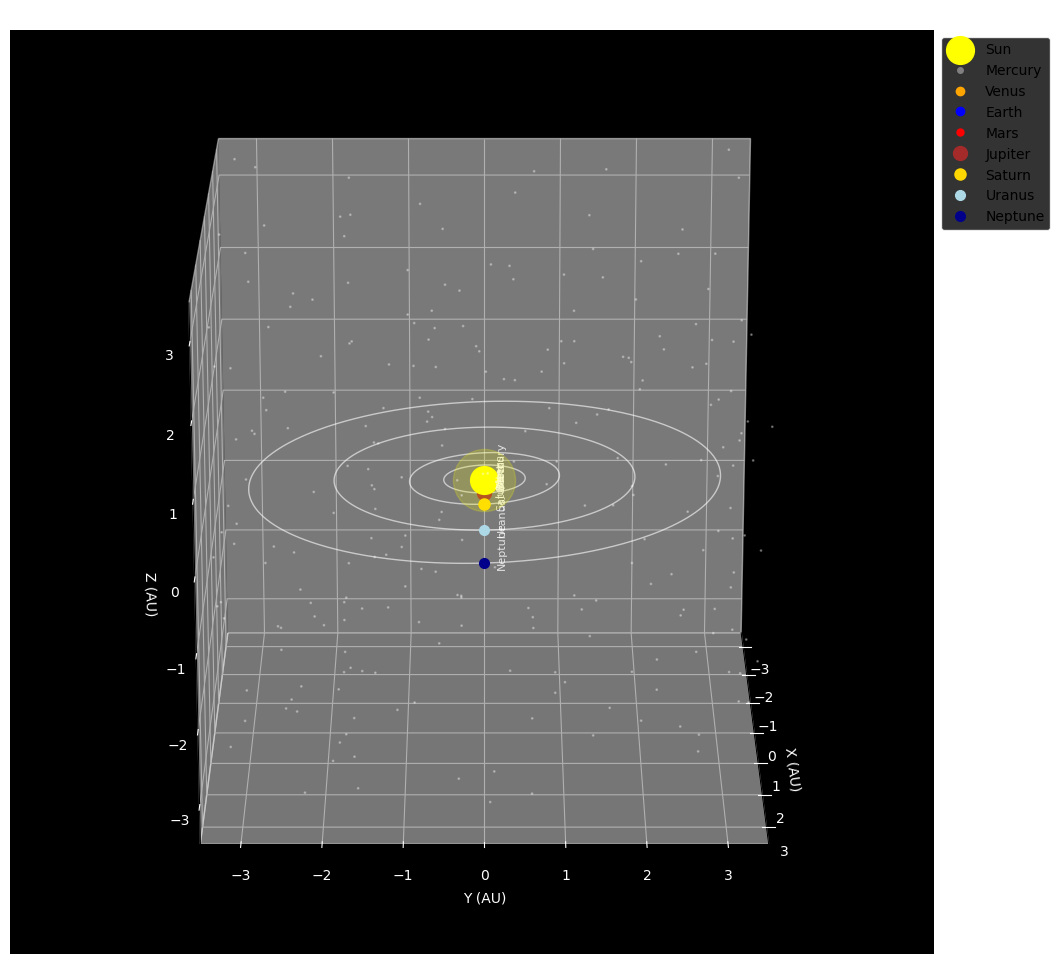

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# planet data
planet_names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
semi_major_axis = [0.39, 0.72, 1.0, 1.52, 5.20, 9.58, 19.20, 30.05]  # AU
eccentricity = [0.205, 0.007, 0.017, 0.093, 0.049, 0.056, 0.046, 0.010]
inclination = [7.0, 3.4, 0.0, 1.85, 1.3, 2.49, 0.77, 1.77]  # degrees
orbital_period = [0.24, 0.62, 1.0, 1.88, 11.86, 29.46, 84.01, 164.8]  # years
planet_colors = ['gray', 'orange', 'blue', 'red', 'brown', 'gold', 'lightblue', 'darkblue']
planet_sizes = [4, 6, 6, 5, 10, 8, 7, 7]

#  moon data
moons = {
    'Earth': {
        'semi_major_axis': [0.00257], 'orbital_period': [0.0748], 'color': ['lightgray'], 'size': [1.5]
    },
    'Jupiter': {
        'semi_major_axis': [0.00282, 0.00449, 0.00715, 0.01259],
        'orbital_period': [0.002, 0.004, 0.007, 0.018],
        'color': ['gray', 'lightblue', 'beige', 'white'],
        'size': [1.2, 1.2, 1.2, 1.2]
    }
}

# Scale factor to fit all orbits in plot nicely
scale_factor = 10

# Scale planet semi-major axes
scaled_semi_major_axis = [a / scale_factor for a in semi_major_axis]

# Scale moon semi-major axes accordingly
scaled_moons = {}
for pname, data in moons.items():
    scaled_moons[pname] = {
        'semi_major_axis': [ma / scale_factor for ma in data['semi_major_axis']],
        'orbital_period': data['orbital_period'],
        'color': data['color'],
        'size': data['size']
    }

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor("black")

# Sun (center)
ax.scatter(0, 0, 0, color='yellow', s=400, label='Sun')
ax.scatter(0, 0, 0, color='yellow', alpha=0.2, s=2000)  # Sun glow

# Background stars
np.random.seed(0)
star_x = np.random.uniform(-3.5, 3.5, 250)
star_y = np.random.uniform(-3.5, 3.5, 250)
star_z = np.random.uniform(-3.5, 3.5, 250)
ax.scatter(star_x, star_y, star_z, color='white', s=1, alpha=0.3)

# Precompute planet orbits (rings)
theta = np.linspace(0, 2*np.pi, 500)
planet_orbits = []
for a, e, inc in zip(scaled_semi_major_axis, eccentricity, inclination):
    b = a * np.sqrt(1 - e**2)
    x = a * np.cos(theta) - a*e
    y = b * np.sin(theta)
    inc_rad = np.radians(inc)
    z = y * np.sin(inc_rad)
    y = y * np.cos(inc_rad)
    planet_orbits.append((x, y, z))
    ax.plot(x, y, z, linestyle='-', color='white', alpha=0.6, linewidth=1)

# Precompute moon orbit circles in local plane (unit circle in XY)
moon_theta = np.linspace(0, 2*np.pi, 100)

# Plot moon orbit lines and store data
moon_orbit_lines = []  # store line objects to update position with planet

for planet_idx, pname in enumerate(planet_names):
    if pname in scaled_moons:
        a_planet = scaled_semi_major_axis[planet_idx]
        e_planet = eccentricity[planet_idx]
        inc_planet = inclination[planet_idx]
        inc_rad = np.radians(inc_planet)
        b_planet = a_planet * np.sqrt(1 - e_planet**2)

        moon_data = scaled_moons[pname]
        for ma in moon_data['semi_major_axis']:
            # Moon orbit circle in local coords (around planet center)
            mx_local = ma * np.cos(moon_theta)
            my_local = ma * np.sin(moon_theta)
            # Apply same inclination tilt for moon orbit plane
            mz_local = my_local * np.sin(inc_rad)
            my_local = my_local * np.cos(inc_rad)
            moon_orbit_lines.append(ax.plot([], [], [], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)[0])

# Planets markers
planet_points = [ax.plot([], [], [], 'o', color=planet_colors[i], markersize=planet_sizes[i], label=planet_names[i])[0]
                 for i in range(len(planet_names))]

# Moon markers
moon_points = []
moon_sizes = []
for pdata in scaled_moons.values():
    for c, s in zip(pdata['color'], pdata['size']):
        m, = ax.plot([], [], [], 'o', color=c, markersize=s)
        moon_points.append(m)
        moon_sizes.append(s)

# Labels
planet_labels = []
for i in range(len(planet_names)):
    lbl = ax.text(0, 0, 0, planet_names[i], color='white', fontsize=8, alpha=0.8)
    planet_labels.append(lbl)

ax.set_xlabel('X (AU)', color='white')
ax.set_ylabel('Y (AU)', color='white')
ax.set_zlabel('Z (AU)', color='white')
ax.set_title('Orbital Visualization of Planets and Moons (Scaled)', color='white')
ax.set_box_aspect([1, 1, 1])
ax.tick_params(colors='white')

# Set limits to encompass Neptune orbit scaled with margin
limit = 3.5  # Since we scaled by 10, Neptune orbit ~3.0 AU scaled
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

def update(frame):
    time = frame / 100
    moon_idx = 0
    moon_orbit_idx = 0
    for i, (a, e, inc, T) in enumerate(zip(scaled_semi_major_axis, eccentricity, inclination, orbital_period)):
        b = a * np.sqrt(1 - e**2)
        inc_rad = np.radians(inc)
        angle = 2 * np.pi * (time / T)

        # Planet position
        px = a * np.cos(angle) - a*e
        py = b * np.sin(angle)
        pz = py * np.sin(inc_rad)
        py = py * np.cos(inc_rad)

        planet_points[i].set_data([px], [py])
        planet_points[i].set_3d_properties([pz])

        # Label with small offset
        offset = 0.15
        planet_labels[i].set_position((px + offset, py + offset))
        planet_labels[i].set_3d_properties(pz)

        # Move and draw moon orbits around the planet center
        if planet_names[i] in scaled_moons:
            moon_data = scaled_moons[planet_names[i]]
            for ma in moon_data['semi_major_axis']:
                # Moon orbit circle in local coords
                mx_local = ma * np.cos(moon_theta)
                my_local = ma * np.sin(moon_theta)
                mz_local = my_local * np.sin(inc_rad)
                my_local = my_local * np.cos(inc_rad)

                # Translate moon orbit circle to planet position
                moon_orbit_lines[moon_orbit_idx].set_data(px + mx_local, py + my_local)
                moon_orbit_lines[moon_orbit_idx].set_3d_properties(pz + mz_local)
                moon_orbit_idx += 1

            # Animate moons moving on those orbits
            for ma, mt, col in zip(moon_data['semi_major_axis'], moon_data['orbital_period'], moon_data['color']):
                m_angle = 2 * np.pi * (time / mt)
                mx_local = ma * np.cos(m_angle)
                my_local = ma * np.sin(m_angle)
                mz_local = my_local * np.sin(inc_rad)
                my_local = my_local * np.cos(inc_rad)

                mx = px + mx_local
                my = py + my_local
                mz = pz + mz_local

                moon_points[moon_idx].set_data([mx], [my])
                moon_points[moon_idx].set_3d_properties([mz])
                moon_idx += 1

    # Rotate camera slowly for 3D effect
    ax.view_init(elev=20, azim=frame * 0.1)

    return planet_points + moon_points + planet_labels + moon_orbit_lines

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), facecolor='black', edgecolor='white')

ani = FuncAnimation(fig, update, frames=2000, interval=20, blit=True)
plt.show()